Mental model is pick the learning rate just before the loss starts to rapidly decrease.

In [1]:
import math
import random

import numpy as np
import openml
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

seed = 1054
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

def get_openmldata(datset_id):

    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="dataframe", target=dataset.default_target_attribute
    )
    print(f"Data has {X.shape[0]} rows and {X.shape[1]} columns.")
    display(X.head())
    display(y.head())

    for col in X.columns[categorical_indicator]:
        X[col] = X.loc[:,col].astype("category")
        X[col] = X.loc[:,col].cat.codes.astype("int32")
    
    return X, y, categorical_indicator

class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, categorical_features, continuous_features):
        super(TabularDataset, self).__init__()
        self.X_categorical = torch.tensor(X[categorical_features].values, dtype=torch.long)
        self.X_continuous = torch.tensor(X[continuous_features].values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (self.X_categorical[idx], self.X_continuous[idx], self.y[idx])

dataset_id = 45045 # Zurich delays: https://www.openml.org/search?type=data&sort=runs&id=45045&status=active
# dataset_id = 44059 # Diamonds: https://www.openml.org/search?type=data&sort=runs&id=44059&status=active

X, y, categorical_indicator = get_openmldata(dataset_id)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = .3)

categorical_features = X.columns[np.array(categorical_indicator)]
continuous_features = X.columns[~np.array(categorical_indicator)]

train_dataset =  TabularDataset(X_train, y_train, categorical_features, continuous_features)
train_loader = DataLoader(train_dataset, batch_size = 512, shuffle=True)

class TabularTransformer(nn.Module):
    def __init__(self, num_continuous_features, num_categories, num_category_embeddings, embedding_dim, num_heads, hidden_dim, dropout_prob):
        super(TabularTransformer, self).__init__()
        self.category_embeddings = nn.ModuleList([nn.Embedding(num_categories[i], embedding_dim) for i in range(num_category_embeddings)])
        self.total_embedding_dim = embedding_dim * num_category_embeddings
        self.continuous_layer = nn.Linear(num_continuous_features, embedding_dim)
        self.total_embedding_dim += embedding_dim
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=self.total_embedding_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout_prob)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=2)
        self.output_layer = nn.Linear(self.total_embedding_dim, 1)

    def forward(self, x_categorical, x_continuous):
        categorical_embeddings = [self.category_embeddings[i](x_categorical[:, i]) for i in range(x_categorical.shape[1])]
        categorical_embeddings = torch.cat(categorical_embeddings, dim=1)
        continuous_embedding = F.relu(self.continuous_layer(x_continuous))
        x = torch.cat([categorical_embeddings, continuous_embedding], dim=1)
        x = self.transformer_encoder(x)
        x = self.output_layer(x)
        return x.squeeze()

model = TabularTransformer(
    num_continuous_features = len(continuous_features), 
    num_categories = [len(set(X[col])) for col in categorical_features], 
    num_category_embeddings = len(categorical_features), 
    embedding_dim = 200, 
    num_heads = 2, 
    hidden_dim = 200, 
    dropout_prob = 0.2
    )

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01)

# Define the learning rate range test function
def lr_range_test(model, train_loader, criterion, optimizer, init_value=1e-8, final_value=10.0, beta=0.98):
    num_batches = len(train_loader)
    avg_loss = 0.0
    best_loss = 0.0
    losses = []
    log_lrs = []
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    
    # We're going to run through one epoch of training.
    for batch_num, (inputs_cat, inputs_cont, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs_cat, inputs_cont)
        loss = criterion(outputs, targets)
        # Smooth loss for interpretation.
        avg_loss = beta * avg_loss + (1 - beta) * loss.item()
        smoothed_loss = avg_loss / (1 - beta ** (batch_num + 1))
        # Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            print(f"Loss is exploding, stopping")
            return log_lrs, losses
        # Record the best loss
        if smoothed_loss < best_loss or batch_num == 0:
            best_loss = smoothed_loss
        # Store the values
        losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))
        # Do the backpropagation and optimization step
        loss.backward()
        optimizer.step()
        # Update the learning rate
        lr *= 1.01
        optimizer.param_groups[0]['lr'] = lr
        
    return log_lrs, losses

# Run the learning rate range test
log_lrs, losses = lr_range_test(model, train_loader, criterion, optimizer)

Data has 5465575 rows and 11 columns.


,vehicle_type,direction,weekday,temp,windspeed_max,windspeed_avg,precipitation,dew_point,humidity,hour,dayminute
0,1,0,0,0.9,1.9,1.4,0.0,0.6,98,5,300.0
1,1,0,0,0.9,1.9,1.4,0.0,0.6,98,5,300.0
2,1,0,0,0.9,1.9,1.4,0.0,0.6,98,5,300.0
3,1,0,0,0.9,1.9,1.4,0.0,0.6,98,5,300.0
4,1,0,0,0.9,1.9,1.4,0.0,0.6,98,5,300.0


0    4.510860
1    4.465908
2    3.637586
3    3.951244
4    3.912023
Name: delay, dtype: float64

Loss is exploding, stopping


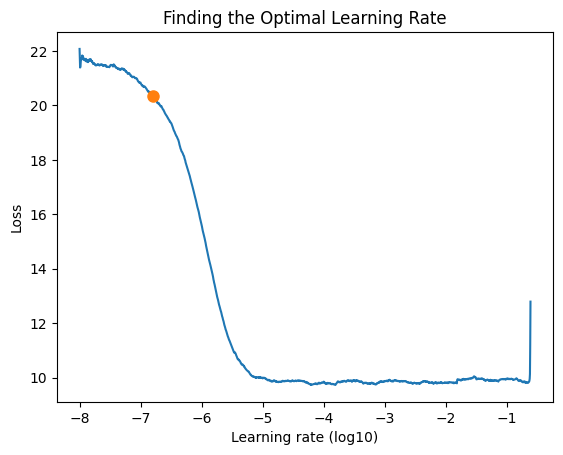

Try a learning rate of 10^-7


In [12]:
# Plot the results
import matplotlib.pyplot as plt
plt.plot(log_lrs, losses)
idx = 280
plt.plot(log_lrs[idx], losses[idx], marker="o", markersize=8, markerfacecolor="tab:orange")
plt.xlabel("Learning rate (log10)")
plt.ylabel("Loss")
plt.title("Finding the Optimal Learning Rate")
plt.show()
print(f"Try a learning rate of 10^{log_lrs[idx]:.0f}")